## **Model 3: Resize + Normalize + Augmentation**

**Load dataset and resize**

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Dataset with normalization
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 42

train_dir = "datasets/Training"
test_dir  = "datasets/Testing"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


**Validation split**

In [2]:
val_size = int(0.2 * len(train_ds))
val_ds = train_ds.take(val_size)
train_ds = train_ds.skip(val_size)

**Normalization + Augmentation**

In [3]:
normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),   # only horizontal, not vertical
    layers.RandomRotation(0.1),        # smaller rotation
    layers.RandomZoom(0.1)             # smaller zoom
])

**Apply transformations**

In [4]:
train_ds = train_ds.map(lambda x, y: (normalization_layer(data_augmentation(x)), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))

**Prefetch**

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

**Build CNN (same as before)**

In [17]:
def build_cnn(input_shape=(128,128,3), num_classes=4):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model3 = build_cnn()
model3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

**Compile**

In [18]:
model3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

**Train**

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        min_delta=1e-3,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='models/model03_best.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

# Train with callbacks
history3 = model3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,   # more epochs, early stopping will prevent overtraining
    callbacks=callbacks
)

# Load best model (lowest val_loss)
best_model3 = tf.keras.models.load_model('models/model03_best.h5')

Epoch 1/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.5480 - loss: 0.9972
Epoch 1: val_loss improved from None to 1.25591, saving model to models/model03_best.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 34s 216ms/step - accuracy: 0.6518 - loss: 0.8180 - val_accuracy: 0.5571 - val_loss: 1.2559 - learning_rate: 0.0010
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.8008 - loss: 0.5430
Epoch 2: val_loss improved from 1.25591 to 1.02583, saving model to models/model03_best.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 27s 185ms/step - accuracy: 0.8020 - loss: 0.5149 - val_accuracy: 0.6821 - val_loss: 1.0258 - learning_rate: 0.0010
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.8515 - loss: 0.3873
Epoch 3: val_loss improved from 1.02583 to 0.41531, saving model to models/model03_best.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 25s 170ms/step - accuracy: 0.8513 - loss: 0.3906 - val_accuracy: 0.8562 - val_loss: 0.4153 - learning_rate: 0.0010
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8902 - loss: 0.3010
Epoch 4: val_loss did not improve from 0.41531
144/144 ━━━━━━━━━━━━━━━━━━━━ 25s 173ms/step - accuracy: 0.8944 - loss: 0.2906 - val_accuracy: 0.8232 - val_loss: 0.5272 - learning_rate: 0.0010
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.9214 - loss: 0.2050
Epoch 5: val_loss did not improve from 0.41531
144/144 ━━━━━━━━━━━━━━━━━━━━ 26s 181ms/step - accuracy: 0.9275 - loss: 0.1891 - val_accuracy: 0.8554 - val_loss: 0.4358 - learning_rate: 0.0010
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9379 - loss: 0.1563
Epoch 6: val_loss did not improve from 0.41531

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
144/144 ━━━━━━━━━━━━━━━━━━━━ 26s 181ms/step - accuracy: 0.9466 - loss: 0.1370 - val_ac

**Evaluate**

In [20]:
# Evaluate on test set
test_loss, test_acc = model3.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Get final training & validation metrics
final_train_acc = history3.history['accuracy'][-1]
final_train_loss = history3.history['loss'][-1]
final_val_acc   = history3.history['val_accuracy'][-1]
final_val_loss  = history3.history['val_loss'][-1]

print(f"Final training accuracy: {final_train_acc:.4f}")
print(f"Final training loss: {final_train_loss:.4f}")
print(f"Final validation accuracy: {final_val_acc:.4f}")
print(f"Final validation loss: {final_val_loss:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7864 - loss: 0.6531
Test accuracy: 0.7864
Test loss: 0.6531
Final training accuracy: 0.9869
Final training loss: 0.0449
Final validation accuracy: 0.8804
Final validation loss: 0.5312


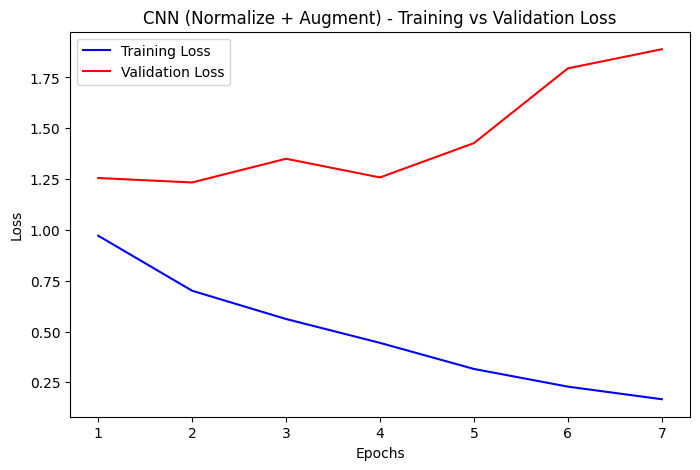

In [10]:
import matplotlib.pyplot as plt

def plot_loss_curves(history, model_name="Model"):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title(f'{model_name} - Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Call for Model 3
plot_loss_curves(history3, model_name="CNN (Normalize + Augment)")


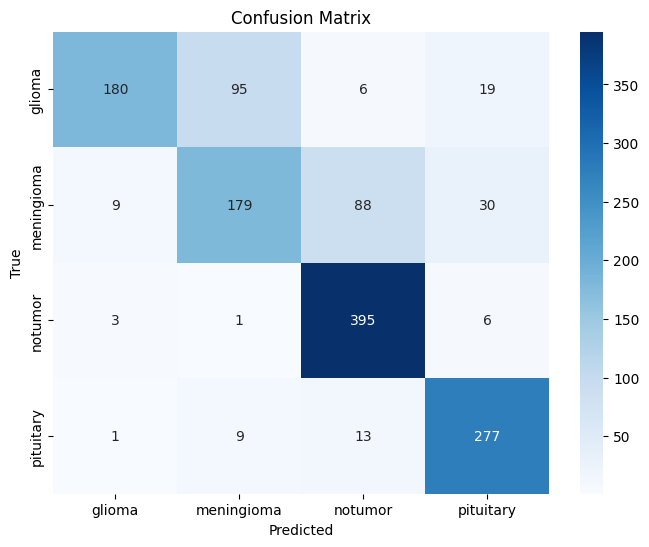


Classification Report:

              precision    recall  f1-score   support

      glioma       0.93      0.60      0.73       300
  meningioma       0.63      0.58      0.61       306
     notumor       0.79      0.98      0.87       405
   pituitary       0.83      0.92      0.88       300

    accuracy                           0.79      1311
   macro avg       0.80      0.77      0.77      1311
weighted avg       0.79      0.79      0.78      1311



In [6]:
from plot_utils import plot_confusion_matrix_from_dataset

class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Confusion matrix from saved model
plot_confusion_matrix_from_dataset("models/model03_best.h5", test_ds, class_names)
